## Interaction-Aware Motion Planning for Autonomous Vehicles with Multi-Modal Obstacle Uncertainty Predictions
### This case corresponds to Case 3 of the paper,where the ISA-MPC is examined in the highD dataset
### The safety-awareness parameter is defined in Line 11 of Section 6.2, you need to change the parameter to 0.1, 0.3, 0.8, respectively, to reproduce the results

### 1. Import

In [1]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import casadi
import scipy.linalg as sl
from numpy.linalg import matrix_power
from scipy.io import loadmat
from Initialization_SV import Initialization_SV
from Initialization_EV import Initialization_EV
from IAIMM_KF import IAIMM_KF
from ISA_MPC import ISA_MPC

import pdb

%matplotlib inline

### 2. Some Predefined Functions

In [2]:
class Priority_Sort( ): # Define the priority list in IAIMM-KF
    
    def __init__(self,  infinity, L_Bound, N_Car, N, Ts):
        self.N_Car = N_Car
        self.N = N
        self.Ts = Ts
        self.L_Bound = L_Bound
        self. infinity =  infinity
    
    def Define_lane_location(self, Lane_position):
        L_Bound = self.L_Bound
        
        if (L_Bound[0] <= Lane_position< L_Bound[1]):
            Lane_position = 1
        elif (L_Bound[1] <= Lane_position < L_Bound[2]):
            Lane_position = 2
        elif  (L_Bound[2] <= Lane_position):
            Lane_position = 3
        
        return Lane_position
    
    def Sort(self, Y_k):
        N_Car = self.N_Car
        N = self.N
        Ts = self.Ts
        infinity = self. infinity
        
        list_priority = np.zeros((2, N_Car))
        list_priority[0, :] = range(0, N_Car)
        x_initial_1 = list([infinity]*N_Car)     
        x_terminal_1 = list([infinity]*N_Car) 
        x_initial_2 = list([infinity]*N_Car)     
        x_terminal_2 = list([infinity]*N_Car) 
        x_initial_3 = list([infinity]*N_Car)     
        x_terminal_3 = list([infinity]*N_Car) 
        
        for i in range(N_Car):
            Lane_location = self.Define_lane_location(Y_k[i][2])
            if Lane_location == 1: 
                x_initial_1[i] = Y_k[i][0]
                x_terminal_1[i] = Y_k[i][0] + Y_k[i][1]*N*Ts
            elif Lane_location == 2: 
                x_initial_2[i] = Y_k[i][0]
                x_terminal_2[i] = Y_k[i][0] + Y_k[i][1]*N*Ts
            elif Lane_location == 3: 
                x_initial_3[i] = Y_k[i][0]
                x_terminal_3[i] = Y_k[i][0] + Y_k[i][1]*N*Ts

        for i in range(N_Car):
            x_initial_index_min_1 = np.argmin(x_initial_1)
            x_terminal_min_1 = x_terminal_1[x_initial_index_min_1] 

            x_initial_index_min_2 = np.argmin(x_initial_2) 
            x_terminal_min_2 = x_terminal_2[x_initial_index_min_2] 
            
            x_initial_index_min_3 = np.argmin(x_initial_3) 
            x_terminal_min_3 = x_terminal_3[x_initial_index_min_3] 
            
            index_terminal = np.argmin([x_terminal_min_1, x_terminal_min_2, x_terminal_min_3])
            
            if index_terminal == 0:
                index = x_initial_index_min_1
                x_initial_1[index] = infinity
                x_terminal_1[index] = infinity
            elif index_terminal == 1:
                index = x_initial_index_min_2
                x_initial_2[index] = infinity
                x_terminal_2[index] = infinity
            elif index_terminal == 2:
                index = x_initial_index_min_3
                x_initial_3[index] = infinity
                x_terminal_3[index] = infinity
            
            list_priority[1, index] = i
        
        list_use = list_priority[1, :] 
        return list_use

def Cal_Vertex(x, y, theta, l, w): 
    box = np.array([[x-l/2, y+w/2], [x+l/2, y+w/2], [x+l/2, y-w/2], [x-l/2, y-w/2]])
    box_matrix = box - np.tile([x, y], (box.shape[0], 1))
    theta = -theta
    rota_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    new = np.dot(box_matrix, rota_matrix) + np.tile([x, y], (box.shape[0], 1))
    
    x = [new[0, 0], new[1, 0], new[2, 0], new[3, 0], new[0, 0]]
    y = [new[0, 1], new[1, 1], new[2, 1], new[3, 1], new[0, 1]]
    
    return x, y 

def OCC_SV_Vertex(OCC_Obstacle): # Visualize the occupancy (occ.) of the SV
    x_bar = OCC_Obstacle[0]
    y_bar = OCC_Obstacle[1]
    dx = OCC_Obstacle[2]
    dy = OCC_Obstacle[3]
    
    xe1 = x_bar - dx
    xe2 = x_bar + dx
    xe3 = x_bar + dx 
    xe4 = x_bar - dx
    
    ye1 = y_bar - dy 
    ye2 = y_bar - dy
    ye3 = y_bar + dy
    ye4 = y_bar + dy
    
    X = [xe1, xe2, xe3, xe4, xe1]    
    Y = [ye1, ye2, ye3, ye4, ye1]
    return X, Y 

### 3. Load Driving Model Parameters

In [3]:
# The file 'Model_Parameters.mat' contains the parameters of IAIMM-KF, which is identified offline
Model_Parameters = loadmat(r'Model_Parameters.mat')
Model_Parameters = Model_Parameters['Model_Parameters']
Model_Parameters = Model_Parameters[0, 0]

m0 =   [Model_Parameters['m0']['Lon'][0][0][0], Model_Parameters['m0']['Lat'][0][0][0]] 
m1 =   [Model_Parameters['m1']['Lon'][0][0][0], Model_Parameters['m1']['Lat'][0][0][0]] 
m2 =   [Model_Parameters['m2']['Lon'][0][0][0], Model_Parameters['m2']['Lat'][0][0][0]] 
m3 =   [Model_Parameters['m3']['Lon'][0][0][0], Model_Parameters['m3']['Lat'][0][0][0]] 
m4 =   [Model_Parameters['m4']['Lon'][0][0][0], Model_Parameters['m4']['Lat'][0][0][0]] 
m5 =   [Model_Parameters['m5']['Lon'][0][0][0], Model_Parameters['m5']['Lat'][0][0][0]] 
m6 =   [Model_Parameters['m6']['Lon'][0][0][0], Model_Parameters['m6']['Lat'][0][0][0]] 
std_m0 = [Model_Parameters['m0']['K_set_lon'][0][0][0], Model_Parameters['m0']['std_y'][0][0][0]]
std_m1 = [Model_Parameters['m1']['K_set_lon'][0][0][0], Model_Parameters['m1']['K_set_lat'][0][0][0]]
std_m2 = [Model_Parameters['m2']['K_set_lon'][0][0][0], Model_Parameters['m2']['K_set_lat'][0][0][0]]
std_m3 = [Model_Parameters['m3']['K_set_lon'][0][0][0], Model_Parameters['m3']['std_y'][0][0][0]]
std_m4 = [Model_Parameters['m4']['K_set_lon'][0][0][0], Model_Parameters['m4']['K_set_lat'][0][0][0]]
std_m5 = [Model_Parameters['m5']['K_set_lon'][0][0][0], Model_Parameters['m5']['K_set_lat'][0][0][0]]
std_m6 = [Model_Parameters['m6']['K_set_lon'][0][0][0], Model_Parameters['m6']['std_y'][0][0][0]]

Models = [m0, m1, m2, m3, m4, m5, m6] # submodels (controller gains of nominal maneuvers)
std_parameters = [std_m0, std_m1, std_m2, std_m3, std_m4, std_m5, std_m6] # parameters of standard deviation

### 4. Define Basic parameters

In [4]:
# basic parameters
Ts = 0.32                     # time interval
N = 25                        # prediction horizon
N_Lane = 3                    # number of lanes
N_M = 7                       # number of sub-models of SVs
N_Car = 7                     # number of cars involving EV and SVs
L_Width = [4, 3.56, 3.74]     # width of each lane
L_Bound = [0, 4, 7.56, 11.3]  # land boundaries
L_Center = [2, 5.78, 9.43]    # lane center positions
l_veh = 4.3                   # vehicle length
w_veh = 1.82                  # vehicle width
DSV = 6                       # dimension of SVs
Dev =  np.array([0.015, 1.8]) # threshold of phi and y
SpeedLim = np.array([None, None, None]) # speed limit of each lane
Weight = np.array([0.2, 0.1, 0.5, 0.2]) # weight for ax ay vx y → tunable in real traffic scenario 
H = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]])
infinity = 100000
Q = np.diag([1, 0.5, 0.25, 0.1, 0.1, 0])     # Q matrix in Kalman filter -- Tunable
R = np.diag([1, 1, 1])*1e-5                  # R matrix in Kalman filter -- Tunable
miuR = np.array([0, 0, 0])
K_sampling = 30                              # the sampling size for estimating the variance of  x and y

opts_SV = { # parameters of SV
    'Ts': Ts,   
    'N': N,   
    'N_Lane': N_Lane,
    'N_M': N_M,         
    'N_Car': N_Car,     
    'L_Width': L_Width, 
    'w_veh': w_veh,    
    'l_veh': l_veh,
    'L_Bound': L_Bound, 
    'L_Center': L_Center,
    'DSV': DSV, 
    'infinity': infinity,
    'SpeedLim': SpeedLim, 
    'Q': Q, 
    'R': R, 
    'Weight': Weight,
    'H': H,
    'Models': Models,
    'std_parameters': std_parameters,
    'K_sampling': K_sampling
}

### 5. Initialization of Traffic Scenario

In [5]:
index_EV = 7 # the vertual EV, the index
# global initial state of the vehicles from the highD dataset
V0 = np.load('ID452.npy', allow_pickle=True).item( )
V1 = np.load('ID454.npy', allow_pickle=True).item( )
V2 = np.load('ID455.npy', allow_pickle=True).item( )
V3 = np.load('ID456.npy', allow_pickle=True).item( )
V4 = np.load('ID457.npy', allow_pickle=True).item( )
V5 = np.load('ID458.npy', allow_pickle=True).item( )
V6 = np.load('ID459.npy', allow_pickle=True).item( )
SVs = [V0, V1, V2, V3, V4, V5, V6]

x_0_0 = np.array([V0['x'][0], V0['vx'][0], V0['ax'][0], V0['y'][0], -V0['vy'][0], V0['ay'][0]]) # SV0
x_0_1 = np.array([V1['x'][0], V1['vx'][0], V1['ax'][0], V1['y'][0], -V1['vy'][0], V1['ay'][0]]) # SV1
x_0_2 = np.array([V2['x'][0], V2['vx'][0], V2['ax'][0], V2['y'][0], -V2['vy'][0], V2['ay'][0]]) # SV2
x_0_3 = np.array([V3['x'][0], V3['vx'][0], V3['ax'][0], V3['y'][0], -V3['vy'][0], V3['ay'][0]]) # SV3
x_0_4 = np.array([V4['x'][0], V4['vx'][0], V4['ax'][0], V4['y'][0], -V4['vy'][0], V4['ay'][0]]) # SV4
x_0_5 = np.array([V5['x'][0], V5['vx'][0], V5['ax'][0], V5['y'][0], -V5['vy'][0], V5['ay'][0]]) # SV5
x_0_6 = np.array([V6['x'][0], V6['vx'][0], V6['ax'][0], V6['y'][0], -V6['vy'][0], V6['ay'][0]]) # SV6

# saving room of SVs
X_Hat = list( )         # the estimate of state of each mode
MU = list( )            # the probability
P = list( )             # the covariance matrix in IMM-KF
Y = list( )             # the measurement
M = list( )             # the activated model -- models which are effective
X_Pre = list( )         # the prediction
X_Po_All = list( )      # the all possible predictions
Ref_Speed = list( )     # reference speed of cars
Ref_Lane = list( )      # reference lateral position of cars
Ref_Speed_All = list( ) # reference speed of all modes of each car
X_State = list( )       # the state of each car at every step
X_Var = list( )         # the x trajectory variance of all models of all targets 
Y_Var  = list( )        # the y trajectory variance of all models of all targets
Prio_List = list( )     # the priority list

X_State_0 = [x_0_0, x_0_1, x_0_2, x_0_3, x_0_4, x_0_5, x_0_6]
X_State.append(X_State_0) # state at step 0

# initialization of SV
Initial_SV =Initialization_SV(Params = opts_SV)
MU_0, M_0, Y_0, X_Hat_0, P_0, X_Pre_0, X_Po_All_0, X_Var_0, Y_Var_0,  REF_Speed_0, REF_Lane_0, REF_Speed_All_0 = Initial_SV.Initialize_MU_M_P(X_State)

# initial storage for SVs 
MU.append(MU_0)
M.append(M_0)
Y.append(Y_0)
X_Hat.append(X_Hat_0)
X_Pre.append(X_Pre_0)
X_Po_All.append(X_Po_All_0)
X_Var.append(X_Var_0)
Y_Var.append(Y_Var_0)
P.append(P_0)
Ref_Speed.append(REF_Speed_0)
Ref_Lane.append(REF_Lane_0)
Ref_Speed_All.append(REF_Speed_All_0)

# initialize priority
Sorting = Priority_Sort(infinity = infinity, L_Bound = L_Bound, N_Car = N_Car, N = N, Ts = Ts)
Prio_List.append(Sorting.Sort(Y[0]))

### 6. Simulation

#### 6.1 IAIMM-KF Prediction

In [6]:
K_N = 28  # the number of all simulation steps
IMM_KF =  IAIMM_KF(Params = opts_SV)

start = time.perf_counter( )

for k in range(1, K_N):
    Y_k = list( )
    y_k_0 = np.array([V0['x'][k], V0['vx'][k], V0['y'][k]]) + np.random.multivariate_normal(miuR, R)
    y_k_1 = np.array([V1['x'][k], V1['vx'][k], V1['y'][k]]) + np.random.multivariate_normal(miuR, R)
    y_k_2 = np.array([V2['x'][k], V2['vx'][k], V2['y'][k]]) + np.random.multivariate_normal(miuR, R)
    y_k_3 = np.array([V3['x'][k], V3['vx'][k], V3['y'][k]]) + np.random.multivariate_normal(miuR, R)
    y_k_4 = np.array([V4['x'][k], V4['vx'][k], V4['y'][k]]) + np.random.multivariate_normal(miuR, R)
    y_k_5 = np.array([V5['x'][k], V5['vx'][k], V5['y'][k]]) + np.random.multivariate_normal(miuR, R)
    y_k_6 = np.array([V6['x'][k], V6['vx'][k], V6['y'][k]]) + np.random.multivariate_normal(miuR, R)
    Y_k = [y_k_0, y_k_1, y_k_2, y_k_3, y_k_4, y_k_5, y_k_6,]
    list_k = Sorting.Sort(Y_k)
    Y.append(Y_k)
    MU_k            = [None]*N_Car  
    M_k             = [None]*N_Car   
    X_Hat_k         = [None]*N_Car  
    X_State_k       = [None]*N_Car  
    P_k             = [None]*N_Car      
    X_Pre_k         = [None]*N_Car  
    Obst_k          = [None]*N_Car 
    X_Po_All_k      = [None]*N_Car  
    X_Var_k         = [None]*N_Car  
    Y_Var_k         = [None]*N_Car  
    Ref_Speed_k     = [None]*N_Car  
    Ref_Lane_k      = [None]*N_Car 
    Ref_Speed_All_k = [None]*N_Car 
    print('The step is', k)
    for i in range(N_Car):
            car_index = np.argwhere(list_k == np.max(list_k))  
            car_index = car_index[0][0]
            list_k[car_index] = -1
            Ref_speed, Ref_lane, mu_k, m_k, x_hat_k, p_k, x_state_k, x_pre_k,  REF, x_po_all_k, x_var_k, y_var_k = IMM_KF.Final_Return(k, MU, X_Hat, P, Y, Obst_k, car_index)
            Ref_Speed_k[car_index] = Ref_speed
            Ref_Lane_k[car_index] = Ref_lane
            Ref_Speed_All_k[car_index] = REF
            X_State_k[car_index] = x_state_k
            P_k[car_index] = p_k
            X_Po_All_k[car_index] = x_po_all_k    
            Obst_k[car_index] = x_pre_k
            X_Var_k[car_index] = x_var_k
            Y_Var_k[car_index] = y_var_k
            MU_k[car_index] = mu_k
            M_k[car_index] = m_k
            X_Hat_k[car_index] = x_hat_k
            X_Pre_k[car_index] = x_pre_k
                 
    MU.append(MU_k)
    M.append(M_k)
    X_Hat.append(X_Hat_k)
    X_State.append(X_State_k)
    X_Pre.append(X_Pre_k)
    P.append(P_k)
    X_Po_All.append(X_Po_All_k)
    Ref_Speed.append(Ref_Speed_k)
    Ref_Speed_All.append(Ref_Speed_All_k)
    Ref_Lane.append(Ref_Lane_k)
    X_Var.append(X_Var_k)
    Y_Var.append(Y_Var_k)
    list_k = Sorting.Sort(Y_k)
    Prio_List.append(list_k)
    
end = time.perf_counter( )
total_t = end - start
print ('Average excution time: ', total_t/k)

The step is 1

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

The step is 2
The step is 3
The step is 4
The step is 5
The step is 6
The step is 7
The step is 8
The step is 9
The step is 10
The step is 11
The step is 12
The step is 13
The step is 14
The step is 15
The step is 16
The step is 17
The step is 18
The step is 19
The step is 20
The step is 21
The step is 22
The step is 23
The step is 24
The step is 25
The step is 26
The step is 27
Average excution time:  0.14845502429630464


#### 6.2 MPC Initialization

In [7]:
# basic parameters
N_M_EV = 3      # number of sub-models of EV
DEV = 8         # dimension of EV
Th_long = 1     # long time headway  → Tunable in real traffic scenario
Th_short = 0.5  # short time headway → Tunable in real traffic scenario
K_Lon_EV = np.array([0.1029, 0.3423])          # long. controller gains of nominal velocity-tracking maneuver
K_Lat_EV  = np.array([0.0984, 0.4656, 0.5417]) # lat. control gains of nominal lane-tracking maneuver
l_f = 1.446   # vehicle parameter
l_r =1.477    # vehicle parameter
### This is a very important parameter
epsilon = 0.1     # the safety parameter of MPC (epsilon = 1 is deterministic MPC)
### This is a veyr important parameter

opts_EV = { # parameters of EV
    'index_EV': index_EV,
    'Ts': Ts,     
    'N': N,   
    'N_Lane': N_Lane,
    'N_M': N_M, 
    'N_M_EV': N_M_EV, 
    'N_Car': N_Car,  
    'L_Center': L_Center, 
    'L_Bound': L_Bound, 
    'w_veh': w_veh, 
    'l_veh': l_veh,
    'zeta_l': 0.5,
    'zeta_w': 0.5,
    'zeta_EV': 0.5,
    'Th_MPC': Th_short, 
    'Th_QP': Th_long, 
    'DSV': DSV,       
    'DEV': DEV,   
    'Dev': Dev, 
    'K_Lon_EV': K_Lon_EV,
    'K_Lat_EV': K_Lat_EV,
    'l_f': l_f,  
    'l_r': l_r,  
    'SpeedLim': SpeedLim, 
    'Weight': Weight,
    'H': H, 
    'infinity': infinity,
    'Models': Models,
    'Q_Initial': [0.5, 0.1, 0.5, 0.1, 0.05, 1, 0.055],
    'epsilon': epsilon,
    'Q1': 0.5,      # longitudianl snap
    'Q2': 0.1,      # front tire angle acceleration
    'Q3': 0.5,      # longitudinal acceleration
    'Q4': 0.1,      # front tire wheel angle 
    'Q5': 0.05,     #  terminal lateral error
    'Q6': 1,        #  terminal longitudinal position error
    'Q7': 0.055,    # slack variable
}

In [8]:
x_0_EV_glo = x_0_5    # virtual EV is appointed as SV5
x_0_EV_loc = np.array([V5['x'][0], V5['y'][0], -np.arctan2(V5['vy'][0], V5['vx'][0]), V5['vx'][0], V5['ax'][0], 0, 0, 0])

MU_EV = list( )    # the maneuver probability
M_EV = list( )     # the maneuver/model
X_Pre_EV = list( ) # the planned trajectory in prediction horizon
Y_EV = list( )     # measurement of EV
Ref_Speed_EV = list( )      # reference speed
Ref_Speed_All_EV = list( )  # reference speed of all modes
Ref_Lane_EV = list( )       # reference lane
X_State_EV_LOC = list( )    # the local state of ego car at every step
X_State_EV_GLO = list( )    # the global state of EV at every step
Trajectory_EV_LOC = list( ) # the planned trajectory of EV at every step
OCC_SV = list( )            # the OCC obstacle of  all SVs at every step
Prio_List_EV = list( )      # the priority list involve EV

# initialization of EV
Initial_EV = Initialization_EV(Params = opts_EV)
mu_0, m_0,  x_hat_0, x_pre_0, Traj_0, state_1_loc, state_1_glo, y_0, y_1, OCC_SV_0, RefSpeed_EV_0, REF_EV_0  = Initial_EV.Initialization_MPC(x_0_EV_glo, x_0_EV_loc, X_State_0, index_EV, X_Pre_0)

MU_EV.append(mu_0)
M_EV.append(m_0)
X_Pre_EV.append(x_pre_0)
Y_EV.append(y_0)
Y_EV.append(y_1)
Ref_Speed_EV.append(RefSpeed_EV_0)
Ref_Speed_All_EV.append(REF_EV_0)
Ref_Lane_EV.append(L_Center[m_0])
X_State_EV_LOC.append(x_0_EV_loc)   # step 0
X_State_EV_GLO.append(x_0_EV_glo)   # step 0
X_State_EV_LOC.append(state_1_loc)  # step 1
X_State_EV_GLO.append(state_1_glo)  # step 1
OCC_SV.append(OCC_SV_0)
Trajectory_EV_LOC.append(Traj_0)

# initialize priority
Sorting = Priority_Sort(infinity = infinity, L_Bound = L_Bound, N_Car = N_Car+1, N = N, Ts = Ts)
Y_rank_0 = Y[0]
Y_rank_0.append(Y_EV[0])
Prio_List_EV.append( Sorting.Sort(Y_rank_0))

#### 6.2 MPC Planning

In [9]:
K_N = 28 # the number of all simulation steps
N_Car = N_Car + 1
MPC =  ISA_MPC(Params = opts_EV) 
Sorting = Priority_Sort(infinity = infinity, L_Bound = L_Bound, N_Car = N_Car, N = N, Ts = Ts)

start = time.perf_counter( )

for k in range(1, K_N):
    print('The step is', k)
    Y_rank_k = Y[k]
    Y_rank_k.append(Y_EV[k])
    list_EV_k= Sorting.Sort(Y_rank_k)
    Prio_List_EV.append(list_EV_k)
    priority_EV = list_EV_k[-1] 
    TV_involve = np.where(list_EV_k > priority_EV)
    Obst_EV_k = [None]*N_Car
    for i in range(len(TV_involve[0])):
        if TV_involve[0][i] != 5:
            Obst_EV_k[TV_involve[0][i]] = X_Pre[k][TV_involve[0][i]]
    y_k = Y[k][car_index]  
    Ref_speed, Ref_lane, mu_k, m_k, x_hat_k, x_pre_k, Traj_k, state_k_plus_1_loc, state_k_plus_1_glo, y_k_plus_1, OCC_SV_k, REF_Speed_All = MPC.Final_Return(k, X_State_EV_LOC, X_State_EV_GLO, Obst_EV_k, Y_EV[k], X_Po_All[k], MU[k], X_Var[k], Y_Var[k])
    MU_EV.append(mu_k)
    M_EV.append(m_k)
    X_Pre_EV.append(x_pre_k)
    Y_EV.append(y_k_plus_1)
    Ref_Speed_EV.append(Ref_speed)
    Ref_Speed_All_EV.append(REF_Speed_All)
    Ref_Lane_EV.append(Ref_lane)
    X_State_EV_LOC.append(state_k_plus_1_loc)   
    X_State_EV_GLO.append(state_k_plus_1_glo)  
    OCC_SV.append(OCC_SV_k)
    Trajectory_EV_LOC.append(Traj_k)

end = time.perf_counter( )
total_t = end - start
print ('Average excution time: ', total_t/k)

The step is 1
The step is 2
The step is 3
The step is 4
The step is 5
The step is 6
The step is 7
The step is 8
The step is 9
The step is 10
The step is 11
The step is 12
The step is 13
The step is 14
The step is 15
The step is 16
The step is 17
The step is 18
The step is 19
The step is 20
The step is 21
The step is 22
The step is 23
The step is 24
The step is 25
The step is 26
The step is 27
Average excution time:  0.11997578625919737


### 7. Collect the Data for Analysis

In [10]:
t = np.linspace(0, Ts*(K_N-1), K_N) # total simulation time
State_EV_LOC = np.zeros([DEV, K_N]) # collect the state of EV in local system
State_EV_GLO = np.zeros([DSV, K_N]) # collect the state of EV in global system
Ref_Lane_SV_5 = np.zeros([K_N, 1])  # collect the reference lane of SV5
Ref_Speed_SV_5 = np.zeros([K_N, 1]) # collect the reference speed of SV5

for i in range(K_N):
    State_EV_LOC[:, i] = X_State_EV_LOC[i]
    State_EV_GLO[:, i] = X_State_EV_GLO[i]
    Ref_Lane_SV_5[k] = Ref_Lane[k][5]
    Ref_Speed_SV_5[k] = Ref_Speed[k][5]

for k in range(K_N):
    for i in range(N_Car):
        if i == (N_Car-1):
            for j in range(N_M_EV):
                if Ref_Speed_All_EV[k][j] == None:
                    Ref_Speed_All_EV[k][j] = 0
        else:
            for j in range(N_M):
                if Ref_Speed_All[k][i][j] == None:
                    Ref_Speed_All[k][i][j] = 0

### 8. Animation

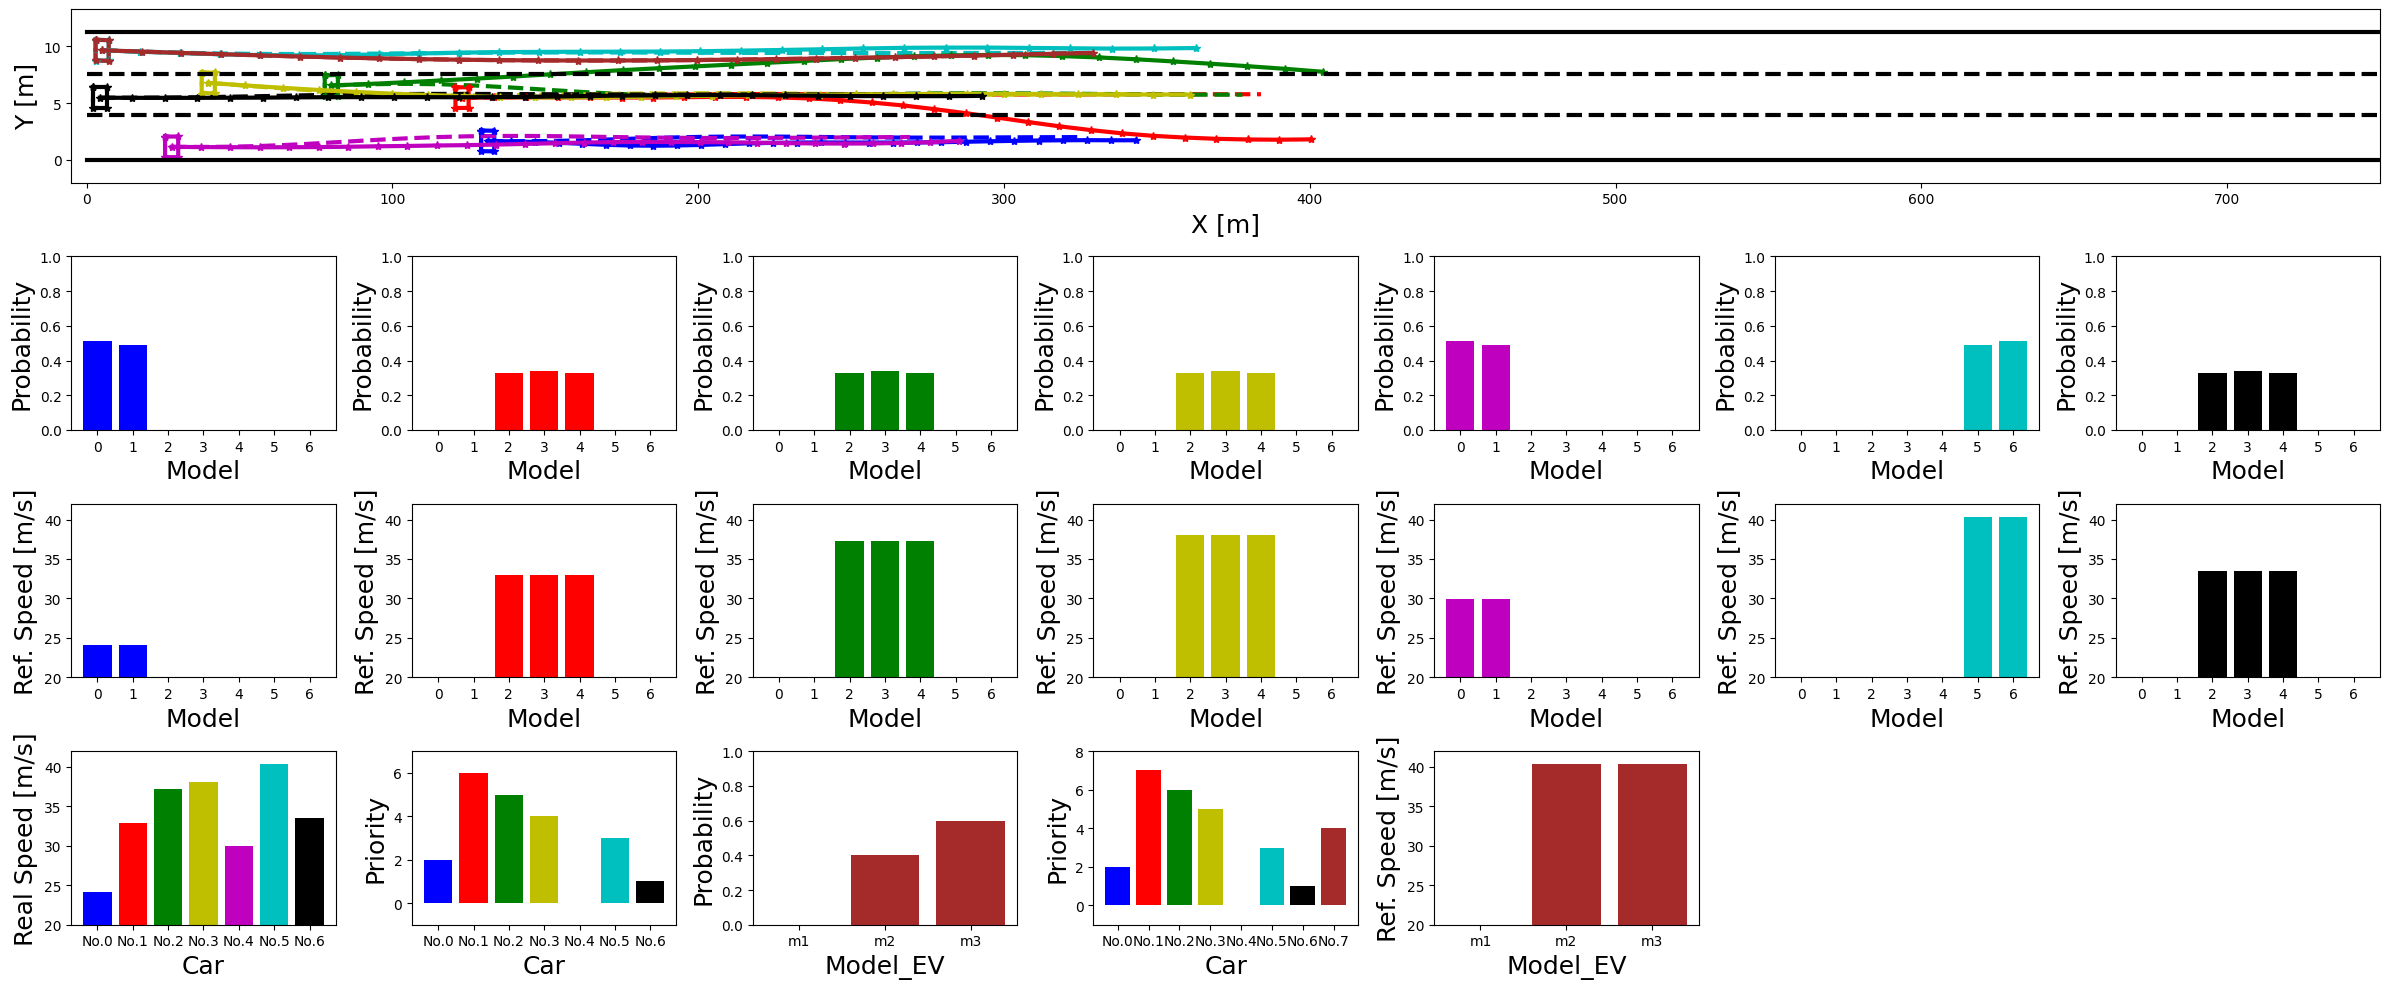

In [11]:
%matplotlib inline
color = ['b', 'r', 'g', 'y', 'm', 'c', 'k', 'brown', 'aqua']
x_max = 750
fig = plt.figure(figsize=(24, 10), tight_layout = True)
ax = fig.add_subplot(4,1,1,xlim=(-5,  x_max), ylim=(-2, L_Bound[-1] - L_Bound[0] + 2))
ax_pro_0 = fig.add_subplot(4, 7, 8,   ylim=(0, 1))
ax_pro_1 = fig.add_subplot(4, 7, 9,   ylim=(0, 1))
ax_pro_2 = fig.add_subplot(4, 7, 10, ylim=(0, 1))
ax_pro_3 = fig.add_subplot(4, 7, 11, ylim=(0, 1))
ax_pro_4 = fig.add_subplot(4, 7, 12, ylim=(0, 1))
ax_pro_5 = fig.add_subplot(4, 7, 13, ylim=(0, 1))
ax_pro_6 = fig.add_subplot(4, 7, 14, ylim=(0, 1))
ax_ref_0 = fig.add_subplot(4, 7, 15, ylim = (20, 42))
ax_ref_1 = fig.add_subplot(4, 7, 16, ylim = (20, 42))
ax_ref_2 = fig.add_subplot(4, 7, 17, ylim = (20, 42))
ax_ref_3 = fig.add_subplot(4, 7, 18, ylim = (20, 42))
ax_ref_4 = fig.add_subplot(4, 7, 19, ylim = (20, 42))
ax_ref_5 = fig.add_subplot(4, 7, 20, ylim = (20, 42))
ax_ref_6 = fig.add_subplot(4, 7, 21, ylim = (20, 42))
ax_real_speed = fig.add_subplot(4, 7, 22, ylim = (20, 42))
ax_prio_list = fig.add_subplot(4, 7, 23, ylim = (-1, 7))
ax_pro_EV = fig.add_subplot(4, 7, 24, ylim = (0, 1))
ax_prio_list_EV = fig.add_subplot(4, 7, 25, ylim = (-1, 8))
ax_ref_EV = fig.add_subplot(4, 7, 26, ylim = (20, 42))
ax.set_xlabel('X [m]', fontsize = 18)
ax.set_ylabel('Y [m]', fontsize = 18)
ax_pro_0.set_xlabel('Model', fontsize = 18)
ax_pro_0.set_ylabel('Probability', fontsize = 18)
ax_pro_1.set_xlabel('Model', fontsize = 18)
ax_pro_1.set_ylabel('Probability', fontsize = 18)
ax_pro_2.set_xlabel('Model', fontsize = 18)
ax_pro_2.set_ylabel('Probability', fontsize = 18)
ax_pro_3.set_xlabel('Model', fontsize = 18)
ax_pro_3.set_ylabel('Probability', fontsize = 18)
ax_pro_4.set_xlabel('Model', fontsize = 18)
ax_pro_4.set_ylabel('Probability', fontsize = 18)
ax_pro_5.set_xlabel('Model', fontsize = 18)
ax_pro_5.set_ylabel('Probability', fontsize = 18)
ax_pro_6.set_xlabel('Model', fontsize = 18)
ax_pro_6.set_ylabel('Probability', fontsize = 18)
ax_ref_0.set_xlabel('Model', fontsize = 18)
ax_ref_0.set_ylabel('Ref. Speed [m/s]', fontsize = 18)
ax_ref_1.set_xlabel('Model', fontsize = 18)
ax_ref_1.set_ylabel('Ref. Speed [m/s]', fontsize = 18)
ax_ref_2.set_xlabel('Model', fontsize = 18)
ax_ref_2.set_ylabel('Ref. Speed [m/s]', fontsize = 18)
ax_ref_3.set_xlabel('Model', fontsize = 18)
ax_ref_3.set_ylabel('Ref. Speed [m/s]', fontsize = 18)
ax_ref_4.set_xlabel('Model', fontsize = 18)
ax_ref_4.set_ylabel('Ref. Speed [m/s]', fontsize = 18)
ax_ref_5.set_xlabel('Model', fontsize = 18)
ax_ref_5.set_ylabel('Ref. Speed [m/s]', fontsize = 18)
ax_ref_6.set_xlabel('Model', fontsize = 18)
ax_ref_6.set_ylabel('Ref. Speed [m/s]', fontsize = 18)
ax_real_speed.set_xlabel('Car', fontsize = 18)
ax_real_speed.set_ylabel('Real Speed [m/s]', fontsize = 18)
ax_prio_list.set_xlabel('Car', fontsize = 18)
ax_prio_list.set_ylabel('Priority', fontsize = 18)
ax_pro_EV.set_xlabel('Model_EV', fontsize = 18)
ax_pro_EV.set_ylabel('Probability', fontsize = 18)
ax_prio_list_EV.set_xlabel('Car', fontsize = 18)
ax_prio_list_EV.set_ylabel('Priority', fontsize = 18)
ax_ref_EV.set_xlabel('Model_EV', fontsize = 18)
ax_ref_EV.set_ylabel('Ref. Speed [m/s]', fontsize = 18)

models = ('0', '1', '2', '3', '4', '5', '6')
car = ('No.0', 'No.1', 'No.2', 'No.3', 'No.4', 'No.5', 'No.6')

models_EV = ('m1', 'm2', 'm3')
car_EV = ('No.0', 'No.1', 'No.2', 'No.3', 'No.4', 'No.5', 'No.6', 'No.7')

prob0 = ax_pro_0.bar(models, MU[0][0], color = color[0])
prob1 = ax_pro_1.bar(models, MU[0][1], color = color[1])
prob2 = ax_pro_2.bar(models, MU[0][2], color = color[2])
prob3 = ax_pro_3.bar(models, MU[0][3], color = color[3])
prob4 = ax_pro_4.bar(models, MU[0][4], color = color[4])
prob5 = ax_pro_5.bar(models, MU[0][5], color = color[5])
prob6 = ax_pro_6.bar(models, MU[0][6], color = color[6])
ref0 = ax_ref_0.bar(models, Ref_Speed_All[0][0], color = color[0])
ref1 = ax_ref_1.bar(models, Ref_Speed_All[0][1], color = color[1])
ref2 = ax_ref_2.bar(models, Ref_Speed_All[0][2], color = color[2])
ref3 = ax_ref_3.bar(models, Ref_Speed_All[0][3], color = color[3])
ref4 = ax_ref_4.bar(models, Ref_Speed_All[0][4], color = color[4])
ref5 = ax_ref_5.bar(models, Ref_Speed_All[0][5], color = color[5])
ref6 = ax_ref_6.bar(models, Ref_Speed_All[0][6], color = color[6])
Real_Speed_0 = [Y[0][0][1], Y[0][1][1], Y[0][2][1], Y[0][3][1], Y[0][4][1], Y[0][5][1], Y[0][6][1]]
real_speed = ax_real_speed.bar(car, Real_Speed_0, color = color[0:7])
priority = ax_prio_list.bar(car, Prio_List[0], color = color)
prob_EV = ax_pro_EV.bar(models_EV, MU_EV[0], color = color[7])
priority_EV = ax_prio_list_EV.bar(car_EV, Prio_List_EV[0], color = color)
ref_EV = ax_ref_EV.bar(models_EV, Ref_Speed_All_EV[0], color = color[7])

state = tuple([ax.plot(np.nan, np.nan, color[k], linewidth=3)[0] for k in range(N_Car)])
trajec = tuple([ax.plot(np.nan, np.nan, color[k], linewidth=3, linestyle='--')[0] for k in range(N_Car)])

state_real = tuple([ax.plot(np.nan, np.nan, color[k], linewidth=3, linestyle=':', marker = '*')[0] for k in range(N_Car)])
trajec_real = tuple([ax.plot(np.nan, np.nan, color[k], linewidth=3, linestyle='-', marker = '*')[0] for k in range(N_Car)])

OCC_SV_0 = tuple([ax.plot(np.nan, np.nan, 'b', linewidth=1)[0] for k in range(N +1)])
OCC_SV_1 = tuple([ax.plot(np.nan, np.nan, 'r', linewidth=1)[0] for k in range(N +1)])
OCC_SV_2 = tuple([ax.plot(np.nan, np.nan, 'g', linewidth=1)[0] for k in range(N +1)])
OCC_SV_3 = tuple([ax.plot(np.nan, np.nan, 'y', linewidth=1)[0] for k in range(N +1)])
OCC_SV_4 = tuple([ax.plot(np.nan, np.nan, 'm', linewidth=1)[0] for k in range(N +1)])
OCC_SV_5 = tuple([ax.plot(np.nan, np.nan, 'brown', linewidth=1)[0] for k in range(N +1)])
OCC_SV_6 = tuple([ax.plot(np.nan, np.nan, 'aqua', linewidth=1)[0] for k in range(N +1)])

def animate(i):
    
    for idx, OCC_SV_i in enumerate(OCC_SV_0):
        if np.sum( OCC_SV[i][0]) == None:
            OCC_SV_i.set_xdata([np.nan, np.nan, np.nan, np.nan, np.nan])
            OCC_SV_i.set_ydata([np.nan, np.nan, np.nan, np.nan, np.nan])
        else:
            x_OCC, y_OCC = OCC_SV_Vertex(OCC_SV[i][0][:, idx])
            OCC_SV_i.set_xdata(x_OCC)
            OCC_SV_i.set_ydata(y_OCC)
    
    for idx, OCC_SV_i in enumerate(OCC_SV_1):
        if np.sum(OCC_SV[i][1]) == None:
            OCC_SV_i.set_xdata([np.nan, np.nan, np.nan, np.nan, np.nan])
            OCC_SV_i.set_ydata([np.nan, np.nan, np.nan, np.nan, np.nan])
        else:
            x_OCC_SV, y_OCC_SV = OCC_SV_Vertex(OCC_SV[i][1][:, idx])
            OCC_SV_i.set_xdata(x_OCC_SV)
            OCC_SV_i.set_ydata(y_OCC_SV)
    
    for idx, OCC_SV_i in enumerate(OCC_SV_2):
        if np.sum(OCC_SV[i][2]) == None:
            OCC_SV_i.set_xdata([np.nan, np.nan, np.nan, np.nan, np.nan])
            OCC_SV_i.set_ydata([np.nan, np.nan, np.nan, np.nan, np.nan])
        else:
            x_OCC_SV, y_OCC_SV = OCC_SV_Vertex( OCC_SV[i][2][:, idx])
            OCC_SV_i.set_xdata(x_OCC_SV)
            OCC_SV_i.set_ydata(y_OCC_SV)
    
    for idx, OCC_SV_i in enumerate(OCC_SV_3):
        if np.sum(OCC_SV[i][3]) == None:
            OCC_SV_i.set_xdata([np.nan, np.nan, np.nan, np.nan, np.nan])
            OCC_SV_i.set_ydata([np.nan, np.nan, np.nan, np.nan, np.nan])
        else:
            x_OCC_SV, y_OCC_SV = OCC_SV_Vertex(OCC_SV[i][3][:, idx])
            OCC_SV_i.set_xdata(x_OCC_SV)
            OCC_SV_i.set_ydata(y_OCC_SV)
    
    for idx, OCC_SV_i in enumerate(OCC_SV_4):
        if np.sum(OCC_SV[i][4]) == None:
            OCC_SV_i.set_xdata([np.nan, np.nan, np.nan, np.nan, np.nan])
            OCC_SV_i.set_ydata([np.nan, np.nan, np.nan, np.nan, np.nan])
        else:
            x_OCC_SV, y_OCC_SV = OCC_SV_Vertex(OCC_SV[i][4][:, idx])
            OCC_SV_i.set_xdata(x_OCC_SV)
            OCC_SV_i.set_ydata(y_OCC_SV)
    
    for idx, OCC_SV_i in enumerate(OCC_SV_5):
        if np.sum(OCC_SV[i][5]) == None:
            OCC_SV_i.set_xdata([np.nan, np.nan, np.nan, np.nan, np.nan])
            OCC_SV_i.set_ydata([np.nan, np.nan, np.nan, np.nan, np.nan])
        else:
            x_OCC_SV, y_OCC_SV = OCC_SV_Vertex(OCC_SV[i][5][:, idx])
            OCC_SV_i.set_xdata(x_OCC_SV)
            OCC_SV_i.set_ydata(y_OCC_SV)
    
    for idx, OCC_SV_i in enumerate(OCC_SV_6):
        if np.sum(OCC_SV[i][6]) == None:
            OCC_SV_i.set_xdata([np.nan, np.nan, np.nan, np.nan, np.nan])
            OCC_SV_i.set_ydata([np.nan, np.nan, np.nan, np.nan, np.nan])
        else:
            x_OCC_SV, y_OCC_SV = OCC_SV_Vertex(OCC_SV[i][6][:, idx])
            OCC_SV_i.set_xdata(x_OCC_SV)
            OCC_SV_i.set_ydata(y_OCC_SV)
    
    for idx, statei in enumerate(state):
        if idx != 7:
            X_State_Est = X_State[i][idx]
        else:
            X_State_Est = X_State_EV_GLO[i]
        
        x_pos = X_State_Est[0]
        y_pos = X_State_Est[3]
        heading = np.arctan(X_State_Est[4]/X_State_Est[1])
        x_state, y_state = Cal_Vertex(x_pos, y_pos, heading, l_veh, w_veh)  
        statei.set_xdata(x_state)
        statei.set_ydata(y_state)
    
    for idx, state_reali in enumerate(state_real):
        if idx != 7:
            X_State_Real = [SVs[idx]['x'][i], SVs[idx]['vx'][i], SVs[idx]['ax'][i], SVs[idx]['y'][i], SVs[idx]['vy'][i], SVs[idx]['ay'][i]]
        else:
            X_State_Real = X_State_EV_GLO[i]
            
        x_pos = X_State_Real[0]
        y_pos = X_State_Real[3]
        heading = np.arctan(X_State_Real[4]/X_State_Real[1])
        x_state, y_state = Cal_Vertex(x_pos, y_pos, heading, l_veh, w_veh) 
        state_reali.set_xdata(x_state)
        state_reali.set_ydata(y_state)
        
    for idx, trajeci in enumerate(trajec):
        if idx != 7:
            trajeci.set_xdata(X_Pre[i][idx][0])
            trajeci.set_ydata(X_Pre[i][idx][3])
        else:
            trajeci.set_xdata(X_Pre_EV[i][0])
            trajeci.set_ydata(X_Pre_EV[i][3])
            
    for idx, trajec_reali in enumerate(trajec_real):
        if idx != 7:
            X_Real = SVs[idx]['x'][i::]
            Y_Real = SVs[idx]['y'][i::]
        else:
            X_Real = X_Pre_EV[i][0]
            Y_Real = X_Pre_EV[i][3]
            
        trajec_reali.set_xdata(X_Real)
        trajec_reali.set_ydata(Y_Real)
    
    for rect0 ,y0i in zip(prob0, MU[i][0]):
        rect0.set_height(y0i)
    for rect1 ,y1i in zip(prob1, MU[i][1]):
        rect1.set_height(y1i)
    for rect2 ,y2i in zip(prob2, MU[i][2]):
        rect2.set_height(y2i)
    for rect3 ,y3i in zip(prob3, MU[i][3]):
        rect3.set_height(y3i)
    for rect4 ,y4i in zip(prob4, MU[i][4]):
        rect4.set_height(y4i)
    for rect5 ,y5i in zip(prob5, MU[i][5]):
        rect5.set_height(y5i)
    for rect6 ,y6i in zip(prob6, MU[i][6]):
        rect6.set_height(y6i)
    
    for rect0, y0i in zip(ref0, Ref_Speed_All[i][0]):
        rect0.set_height(y0i)
    for rect1, y1i in zip(ref1, Ref_Speed_All[i][1]):
         rect1.set_height(y1i)
    for rect2, y2i in zip(ref2, Ref_Speed_All[i][2]):
         rect2.set_height(y2i)
    for rect3, y3i in zip(ref3, Ref_Speed_All[i][3]):
         rect3.set_height(y3i)
    for rect4, y4i in zip(ref4, Ref_Speed_All[i][4]):
         rect4.set_height(y4i)
    for rect5, y5i in zip(ref5, Ref_Speed_All[i][5]):
         rect5.set_height(y5i)
    for rect6, y6i in zip(ref6, Ref_Speed_All[i][6]):
         rect6.set_height(y6i)
    
    Real_Speed_i = [Y[i][0][1], Y[i][1][1], Y[i][2][1], Y[i][3][1], Y[i][4][1], Y[i][5][1], Y[i][6][1]]
    for rect, y in zip(real_speed, Real_Speed_i):
        rect.set_height(y)
    
    for rect, y in zip(priority, Prio_List[i]):
        rect.set_height(y)
    
    for rect_EV, y_EVi in zip(prob_EV, MU_EV[i]):
        rect_EV.set_height(y_EVi)
    
    for rect, y in zip(priority_EV, Prio_List_EV[i]):
        rect.set_height(y)
    
    for rect_EV, y_EVi in zip(ref_EV, Ref_Speed_All_EV[i]):
         rect_EV.set_height(y_EVi)
    
    return OCC_SV_0, OCC_SV_1, OCC_SV_2, OCC_SV_3, OCC_SV_4, OCC_SV_5, OCC_SV_6, state, state_real,  trajec, trajec_real, prob0, prob1, prob2, prob3, prob4, prob5, prob6, ref0, ref1, ref2, ref3, ref4, ref5, ref6, real_speed, priority, prob_EV, priority_EV, ref_EV

ax.plot(np.linspace(0, x_max, num = x_max), np.array([L_Bound[0]]*x_max), 'k', linewidth = 3)
ax.plot(np.linspace(0, x_max, num = x_max), np.array([L_Bound[1]]*x_max), 'k--', linewidth = 3)
ax.plot(np.linspace(0, x_max, num = x_max), np.array([L_Bound[2]]*x_max), 'k--', linewidth = 3)
ax.plot(np.linspace(0, x_max, num = x_max), np.array([L_Bound[3]]*x_max), 'k', linewidth = 3)
            
ani = animation.FuncAnimation(fig, animate, frames = K_N, blit = False)
ani.save('Movie.mp4',writer='ffmpeg', fps=1000/50) # Save to whereever you want

###  9. Save the Data to Whereever You Want

In [12]:
np.save('t.npy', t)
np.save('State_EV_LOC.npy', State_EV_LOC) # state of EV in local coordinate system
np.save('Ref_Speed_EV.npy', Ref_Speed_EV) # reference speed of EV
np.save('Ref_Lane_EV.npy', Ref_Lane_EV)   # reference lane of EV
np.save('State_SV.npy', SVs)              # state of SVs